In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 14a

## Sequential Model using ionosphere putting it together

1. Monitor validation set as well as training set
2. L2 Regularization
3. Dropouts
4. Batch Norm
5. Early stopping

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
# Lets import some libraries
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder

import tensorflow as tf

from utils.helper import fn_plot_tf_hist

%matplotlib inline

2024-05-24 11:39:00.425828: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 11:39:00.425901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 11:39:00.443952: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-24 11:39:00.487132: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 11:39:01.423830: W tensorflow/compiler/tf2

In [3]:
# Some basic parameters

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models'
subDir = 'ionosphere'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
 
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well


EPOCHS = 100         # number of epochs
ALPHA = 0.001        # learning rate
WEIGHT_DECAY = 0.001 # Weight decay
BATCH_SIZE = 16      # other sizes leave last batch partial

TRAIN_SIZE = int(BATCH_SIZE*18)

PATIENCE = 20
LR_PATIENCE = 5
LR_FACTOR = 0.1

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,15),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2024-05-24 11:39:03.632071: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-24 11:39:03.725864: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-24 11:39:03.726097: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Load Data

### Data Set Information:

This radar data was collected by a system in Goose Bay, Labrador. This system consists of a phased array of 16 high-frequency antennas with a total transmitted power on the order of 6.4 kilowatts. See the paper for more details. The targets were free electrons in the ionosphere. "Good" radar returns are those showing evidence of some type of structure in the ionosphere. "Bad" returns are those that do not; their signals pass through the ionosphere.

Received signals were processed using an autocorrelation function whose arguments are the time of a pulse and the pulse number. There were 17 pulse numbers for the Goose Bay system. Instances in this database are described by 2 attributes per pulse number, corresponding to the complex values returned by the function resulting from the complex electromagnetic signal.

Attribute Information:

-- All 34 are continuous
-- The 35th attribute is either "good" or "bad" according to the definition summarized above. This is a binary classification task.

We will model this as two class.

In [5]:
data_df = pd.read_csv(os.path.join(inpDir, subDir, 'ionosphere.data'), header = None)
data_df.shape

(351, 35)

In [6]:
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [7]:
X = data_df.drop(data_df.columns[-1], axis = 1).to_numpy()

y = data_df[data_df.columns[-1]].to_numpy()

In [8]:
X_train, X_test, y_train, y_test = train_test_split( X, y,
                                                   train_size = TRAIN_SIZE,
                                                   stratify=y,
                                                   random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((288, 34), (63, 34), (288,), (63,))

In [9]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)

y_test = le.transform(y_test)

In [10]:
class_name = list(le.classes_)
class_name

['b', 'g']

In [11]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [12]:
## Some model functions

initalizer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA) # using Adam optimizer

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

model1 = tf.keras.models.Sequential([
    
    tf.keras.layers.InputLayer( input_shape =(34,)  ),
    
    tf.keras.layers.Dense (26,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.Dense (18,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer),

   tf.keras.layers.Dense (10,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.Dense (2),
    
])

2024-05-24 11:39:03.850457: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-24 11:39:03.850895: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-24 11:39:03.851130: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [13]:
model1.compile(optimizer=optimizer,
               loss = loss_fn,
               metrics= ['accuracy'])



In [14]:
histroy = model1.fit( x = X_train, 
                     y= y_train,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data=[X_test, y_test],
                    verbose = 2)

Epoch 1/100


2024-05-24 11:39:04.670502: I external/local_xla/xla/service/service.cc:168] XLA service 0x746cfad52960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-24 11:39:04.670548: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-05-24 11:39:04.679818: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-24 11:39:04.705554: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1716530944.786346    4149 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 - 1s - loss: 0.8133 - accuracy: 0.6111 - val_loss: 0.7632 - val_accuracy: 0.6190 - 1s/epoch - 80ms/step
Epoch 2/100
18/18 - 0s - loss: 0.6511 - accuracy: 0.6424 - val_loss: 0.6255 - val_accuracy: 0.6667 - 42ms/epoch - 2ms/step
Epoch 3/100
18/18 - 0s - loss: 0.5558 - accuracy: 0.7396 - val_loss: 0.5480 - val_accuracy: 0.7302 - 42ms/epoch - 2ms/step
Epoch 4/100
18/18 - 0s - loss: 0.4923 - accuracy: 0.8125 - val_loss: 0.4841 - val_accuracy: 0.7937 - 41ms/epoch - 2ms/step
Epoch 5/100
18/18 - 0s - loss: 0.4322 - accuracy: 0.8472 - val_loss: 0.4298 - val_accuracy: 0.8254 - 42ms/epoch - 2ms/step
Epoch 6/100
18/18 - 0s - loss: 0.3756 - accuracy: 0.8681 - val_loss: 0.3808 - val_accuracy: 0.8254 - 43ms/epoch - 2ms/step
Epoch 7/100
18/18 - 0s - loss: 0.3271 - accuracy: 0.8785 - val_loss: 0.3371 - val_accuracy: 0.8413 - 42ms/epoch - 2ms/step
Epoch 8/100
18/18 - 0s - loss: 0.2852 - accuracy: 0.8993 - val_loss: 0.3005 - val_accuracy: 0.8730 - 45ms/epoch - 2ms/step
Epoch 9/100
18/18 - 0s - loss

In [15]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 26)                910       
                                                                 
 dense_1 (Dense)             (None, 18)                486       
                                                                 
 dense_2 (Dense)             (None, 10)                190       
                                                                 
 dense_3 (Dense)             (None, 2)                 22        
                                                                 
Total params: 1608 (6.28 KB)
Trainable params: 1608 (6.28 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
hist_df = pd.DataFrame(histroy.history)
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.813307,0.611111,0.763215,0.619048
1,0.651137,0.642361,0.625524,0.666667
2,0.555767,0.739583,0.548017,0.730159
3,0.492259,0.812500,0.484057,0.793651
4,0.432195,0.847222,0.429809,0.825397


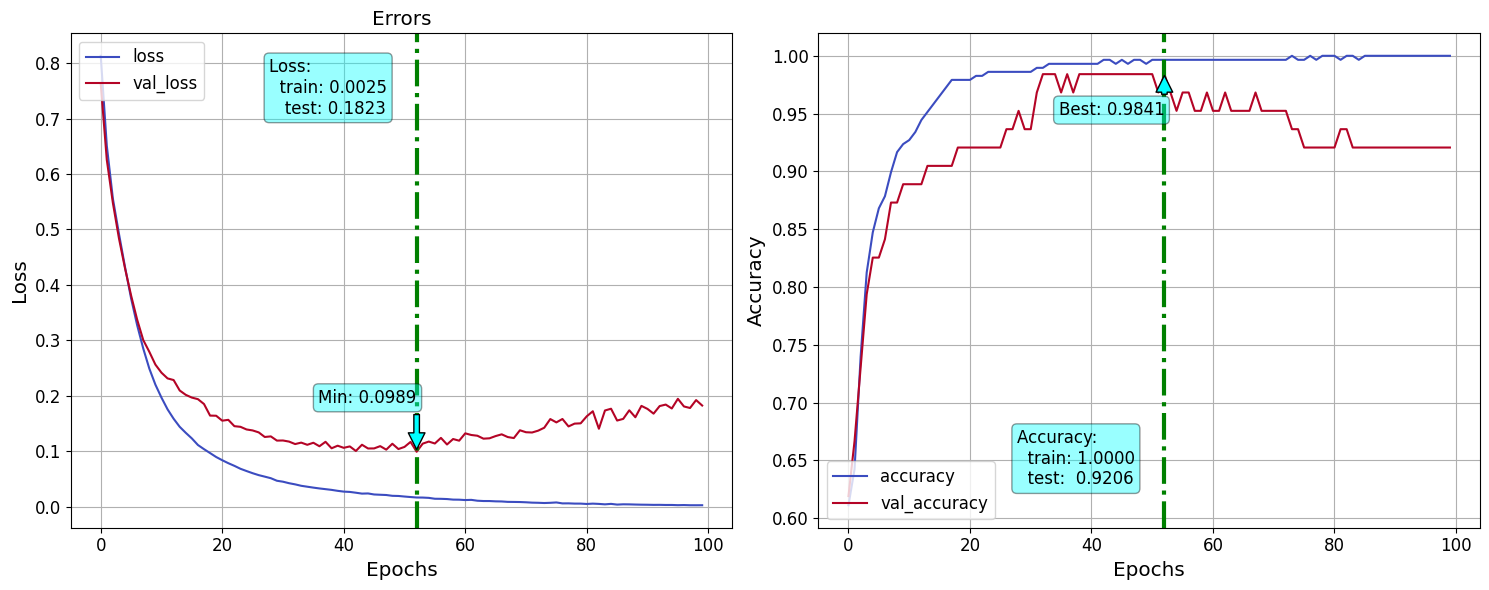

In [17]:
fn_plot_tf_hist(hist_df)

In [18]:
hist_df[hist_df['val_loss'] == hist_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy
52,0.016395,0.996528,0.098938,0.984127


In [19]:
proba_model1 = tf.keras.Sequential([model1,
                                   tf.keras.layers.Softmax()])

y_pred = proba_model1(X_test)

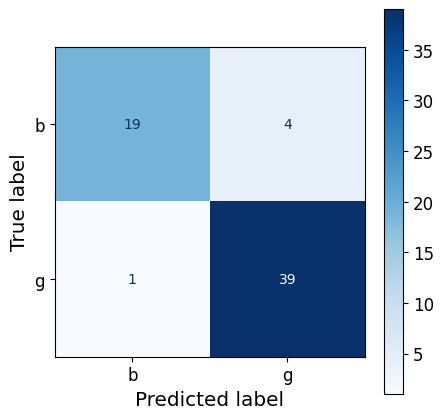

In [20]:
cm = confusion_matrix(y_test, y_pred.numpy().argmax(axis = 1) )

disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels=class_name)

fig, ax = plt.subplots(figsize=(5,5))

disp.plot(ax = ax, cmap = plt.cm.Blues);

## L2 Regularizer

In [21]:
## Some model functions

initalizer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA) # using Adam optimizer

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

regularizer = tf.keras.regularizers.L2(0.05)

model2 = tf.keras.models.Sequential([
    
    tf.keras.layers.InputLayer( input_shape =( 34, ) ),

    tf.keras.layers.Dense (26,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer,
                           kernel_regularizer = regularizer),   # ---- add L2 Regularizer
    
    tf.keras.layers.Dense (18,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer,
                           kernel_regularizer = regularizer),   # ---- add L2 Regularizer

   tf.keras.layers.Dense (10,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer,
                           kernel_regularizer = regularizer),   # ---- add L2 Regularizer
    
    tf.keras.layers.Dense (2),
    
])

model2.compile(optimizer=optimizer,
               loss = loss_fn,
               metrics= ['accuracy'])


history = model2.fit( x = X_train, 
                     y= y_train,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data=[X_test, y_test],
                    verbose = 2)

hist_df = pd.DataFrame(history.history)

Epoch 1/100
18/18 - 1s - loss: 3.5964 - accuracy: 0.6354 - val_loss: 3.3916 - val_accuracy: 0.6349 - 810ms/epoch - 45ms/step
Epoch 2/100
18/18 - 0s - loss: 3.2125 - accuracy: 0.7465 - val_loss: 3.0499 - val_accuracy: 0.7460 - 47ms/epoch - 3ms/step
Epoch 3/100
18/18 - 0s - loss: 2.8886 - accuracy: 0.7917 - val_loss: 2.7506 - val_accuracy: 0.7778 - 47ms/epoch - 3ms/step
Epoch 4/100
18/18 - 0s - loss: 2.6066 - accuracy: 0.8333 - val_loss: 2.4827 - val_accuracy: 0.7937 - 47ms/epoch - 3ms/step
Epoch 5/100
18/18 - 0s - loss: 2.3500 - accuracy: 0.8438 - val_loss: 2.2407 - val_accuracy: 0.8254 - 47ms/epoch - 3ms/step
Epoch 6/100
18/18 - 0s - loss: 2.1177 - accuracy: 0.8681 - val_loss: 2.0240 - val_accuracy: 0.8254 - 46ms/epoch - 3ms/step
Epoch 7/100
18/18 - 0s - loss: 1.9064 - accuracy: 0.8889 - val_loss: 1.8258 - val_accuracy: 0.8413 - 46ms/epoch - 3ms/step
Epoch 8/100
18/18 - 0s - loss: 1.7152 - accuracy: 0.8993 - val_loss: 1.6516 - val_accuracy: 0.8413 - 48ms/epoch - 3ms/step
Epoch 9/100
18

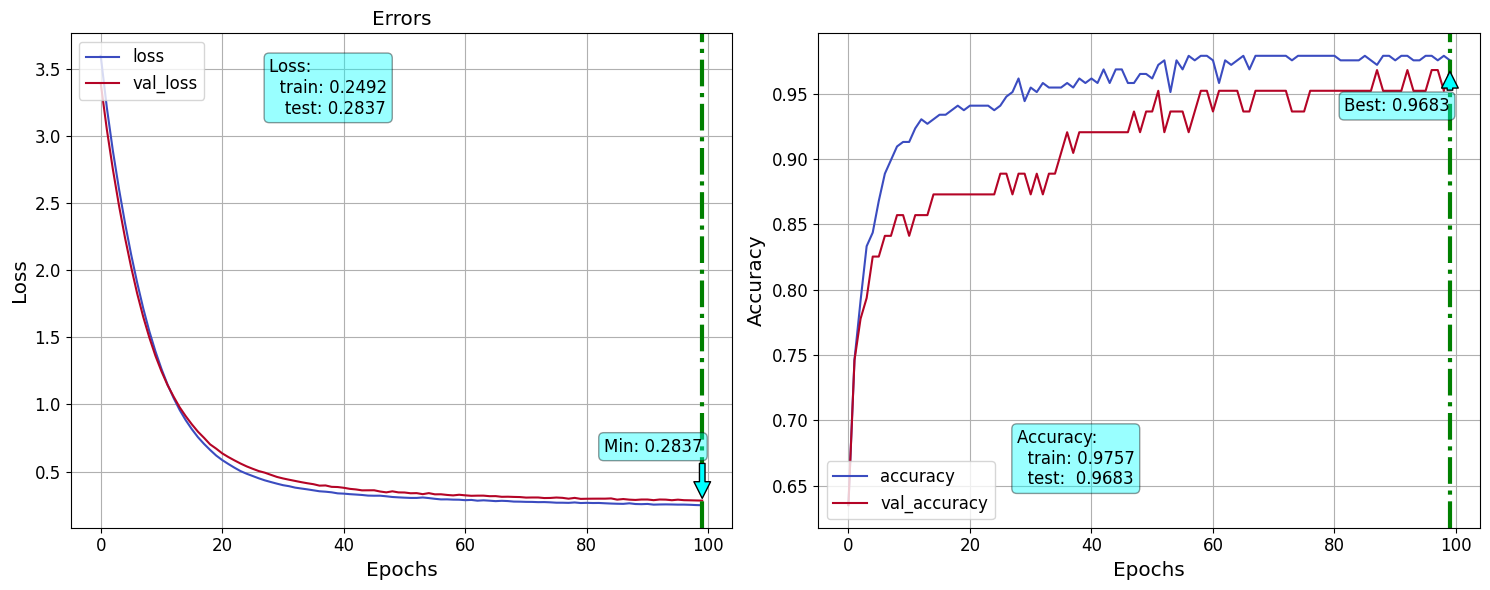

In [22]:
fn_plot_tf_hist(hist_df)

## Batch Normalization

In [23]:
## Some model functions

initalizer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA) # using Adam optimizer

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

model3 = tf.keras.models.Sequential([
    
    tf.keras.layers.InputLayer( input_shape =(34,)  ),
    
    tf.keras.layers.Dense (26,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation(activation='relu'),

    
    tf.keras.layers.Dense (18,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation(activation='relu'),

    tf.keras.layers.Dense (10,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation(activation='relu'),

    tf.keras.layers.Dense (2),
    
])


model3.compile(optimizer=optimizer,
               loss = loss_fn,
               metrics= ['accuracy'])


history = model3.fit( x = X_train, 
                     y= y_train,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data=[X_test, y_test],
                    verbose = 2)

hist_df = pd.DataFrame(history.history)

Epoch 1/100
18/18 - 2s - loss: 0.6613 - accuracy: 0.6979 - val_loss: 0.6998 - val_accuracy: 0.6508 - 2s/epoch - 100ms/step
Epoch 2/100
18/18 - 0s - loss: 0.5327 - accuracy: 0.7847 - val_loss: 0.6400 - val_accuracy: 0.7143 - 72ms/epoch - 4ms/step
Epoch 3/100
18/18 - 0s - loss: 0.4840 - accuracy: 0.8056 - val_loss: 0.5834 - val_accuracy: 0.7619 - 60ms/epoch - 3ms/step
Epoch 4/100
18/18 - 0s - loss: 0.4353 - accuracy: 0.8438 - val_loss: 0.5280 - val_accuracy: 0.7778 - 92ms/epoch - 5ms/step
Epoch 5/100
18/18 - 0s - loss: 0.4254 - accuracy: 0.8333 - val_loss: 0.4723 - val_accuracy: 0.7778 - 66ms/epoch - 4ms/step
Epoch 6/100
18/18 - 0s - loss: 0.3698 - accuracy: 0.8646 - val_loss: 0.4314 - val_accuracy: 0.8254 - 55ms/epoch - 3ms/step
Epoch 7/100
18/18 - 0s - loss: 0.3705 - accuracy: 0.8681 - val_loss: 0.3967 - val_accuracy: 0.8571 - 57ms/epoch - 3ms/step
Epoch 8/100
18/18 - 0s - loss: 0.3560 - accuracy: 0.8819 - val_loss: 0.3690 - val_accuracy: 0.8571 - 58ms/epoch - 3ms/step
Epoch 9/100
18/1

In [24]:
hist_df

,loss,accuracy,val_loss,val_accuracy
0,0.661263,0.697917,0.699807,0.650794
1,0.532659,0.784722,0.640005,0.714286
2,0.483961,0.805556,0.583422,0.761905
3,0.435297,0.843750,0.528031,0.777778
4,0.425404,0.833333,0.472334,0.777778
...,...,...,...,...
95,0.083695,0.975694,0.069408,0.984127
96,0.046091,0.982639,0.071613,0.984127
97,0.101392,0.975694,0.066651,0.984127
98,0.056617,0.989583,0.069122,0.968254


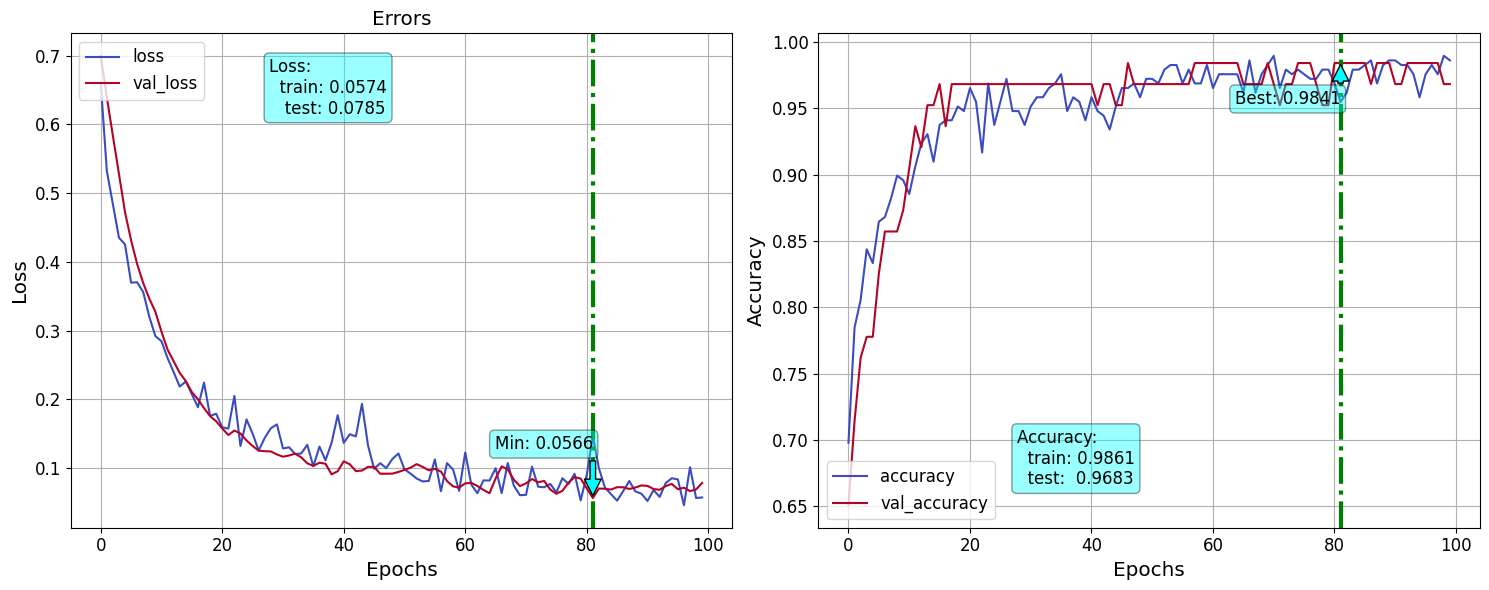

In [25]:
fn_plot_tf_hist(hist_df)

In [26]:
hist_df[hist_df['val_loss'] == hist_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy
81,0.147388,0.954861,0.056557,0.984127


## DROP OUTS

In [27]:
rate1 = 0.2
rate2 = 0.3
rate3 = 0.4

## Some model functions

initalizer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA) # using Adam optimizer

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

model4 = tf.keras.models.Sequential([
    
    tf.keras.layers.InputLayer( input_shape =(34,)  ),
    
    tf.keras.layers.Dense (26,
                           activation = 'relu',
                           kernel_initializer = initalizer),
    
    tf.keras.layers.Dropout(rate1 , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (18,
                           activation = 'relu',
                           kernel_initializer = initalizer),
    
    tf.keras.layers.Dropout(rate2 , seed = RANDOM_STATE),

    tf.keras.layers.Dense (10,
                           activation = 'relu',
                           kernel_initializer = initalizer),
    
    tf.keras.layers.Dropout(rate3 , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (2),
    
])


model4.compile(optimizer=optimizer,
               loss = loss_fn,
               metrics= ['accuracy'])


history = model4.fit( x = X_train, 
                     y= y_train,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data=[X_test, y_test],
                    verbose = 2)

hist_df = pd.DataFrame(history.history)

Epoch 1/100
18/18 - 1s - loss: 0.9222 - accuracy: 0.5556 - val_loss: 0.6795 - val_accuracy: 0.6667 - 1s/epoch - 77ms/step
Epoch 2/100
18/18 - 0s - loss: 0.8052 - accuracy: 0.5938 - val_loss: 0.6307 - val_accuracy: 0.6667 - 44ms/epoch - 2ms/step
Epoch 3/100
18/18 - 0s - loss: 0.6813 - accuracy: 0.6389 - val_loss: 0.5916 - val_accuracy: 0.7619 - 65ms/epoch - 4ms/step
Epoch 4/100
18/18 - 0s - loss: 0.6654 - accuracy: 0.6319 - val_loss: 0.5490 - val_accuracy: 0.7619 - 67ms/epoch - 4ms/step
Epoch 5/100
18/18 - 0s - loss: 0.6080 - accuracy: 0.7118 - val_loss: 0.5173 - val_accuracy: 0.7937 - 43ms/epoch - 2ms/step
Epoch 6/100
18/18 - 0s - loss: 0.5913 - accuracy: 0.7118 - val_loss: 0.4918 - val_accuracy: 0.8095 - 44ms/epoch - 2ms/step
Epoch 7/100
18/18 - 0s - loss: 0.6033 - accuracy: 0.7188 - val_loss: 0.4712 - val_accuracy: 0.8413 - 43ms/epoch - 2ms/step
Epoch 8/100
18/18 - 0s - loss: 0.5454 - accuracy: 0.7604 - val_loss: 0.4503 - val_accuracy: 0.8413 - 44ms/epoch - 2ms/step
Epoch 9/100
18/18

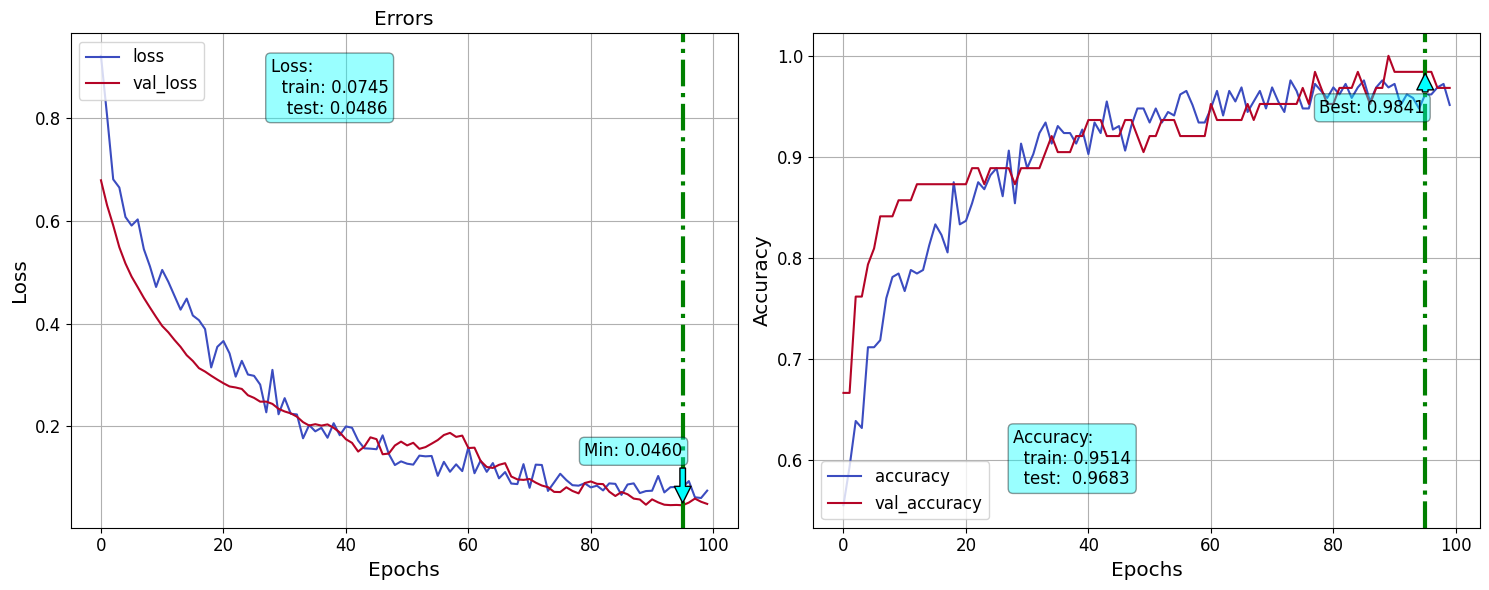

In [28]:
fn_plot_tf_hist(hist_df)

In [29]:
hist_df[hist_df['val_loss'] == hist_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy
95,0.081155,0.961806,0.046005,0.984127


### All In

In [30]:
rate1 = 0.05
rate2 = 0.05
rate3 = 0.05

## Some model functions

initalizer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

optimizer = tf.keras.optimizers.AdamW(learning_rate=ALPHA, weight_decay=WEIGHT_DECAY) # using Adam optimizer

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

# Suppressing regularization
#regularizer = tf.keras.regularizers.L2(0.05)
regularizer = None

model = tf.keras.models.Sequential([
    
    tf.keras.layers.InputLayer( input_shape =(34,)  ),
    
    tf.keras.layers.Dense (26,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation(activation='relu'),

    #tf.keras.layers.Dropout(rate1 , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (18,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation(activation='relu'),

    #tf.keras.layers.Dropout(rate2 , seed = RANDOM_STATE),

    tf.keras.layers.Dense (10,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation(activation='relu'),

    #tf.keras.layers.Dropout(rate3 , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (2),
    
])

model.compile(optimizer=optimizer,
               loss = loss_fn,
               metrics= ['accuracy'])

In [31]:
checkpoint_filepath = os.path.join(modelDir, subDir, 'weights_all_in')

chkpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = 'val_loss',
    mode = 'auto',
    verbose = 2,
    save_best_only = True
)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience=PATIENCE,
    mode='auto',
    verbose = 2,
    baseline =None,
    restore_best_weights=True)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=2,
    mode='auto',
    min_lr=0.00001)

In [32]:
history = model.fit( x = X_train, 
                     y = y_train,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data=[X_test, y_test],
                    verbose = 2,
                    callbacks = [es_callback, chkpt_callback, lr_callback])

hist_df = pd.DataFrame(history.history)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.65899, saving model to ../models/ionosphere/weights_all_in
18/18 - 2s - loss: 0.7707 - accuracy: 0.4757 - val_loss: 0.6590 - val_accuracy: 0.6349 - lr: 0.0010 - 2s/epoch - 87ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.65899 to 0.60080, saving model to ../models/ionosphere/weights_all_in
18/18 - 0s - loss: 0.6243 - accuracy: 0.6910 - val_loss: 0.6008 - val_accuracy: 0.7778 - lr: 0.0010 - 99ms/epoch - 6ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.60080 to 0.54618, saving model to ../models/ionosphere/weights_all_in
18/18 - 0s - loss: 0.5266 - accuracy: 0.7986 - val_loss: 0.5462 - val_accuracy: 0.8413 - lr: 0.0010 - 99ms/epoch - 5ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.54618 to 0.50378, saving model to ../models/ionosphere/weights_all_in
18/18 - 0s - loss: 0.4629 - accuracy: 0.8576 - val_loss: 0.5038 - val_accuracy: 0.9048 - lr: 0.0010 - 96ms/epoch - 5ms/step
Epoch 5/100

Epoch 5: val_loss improved f

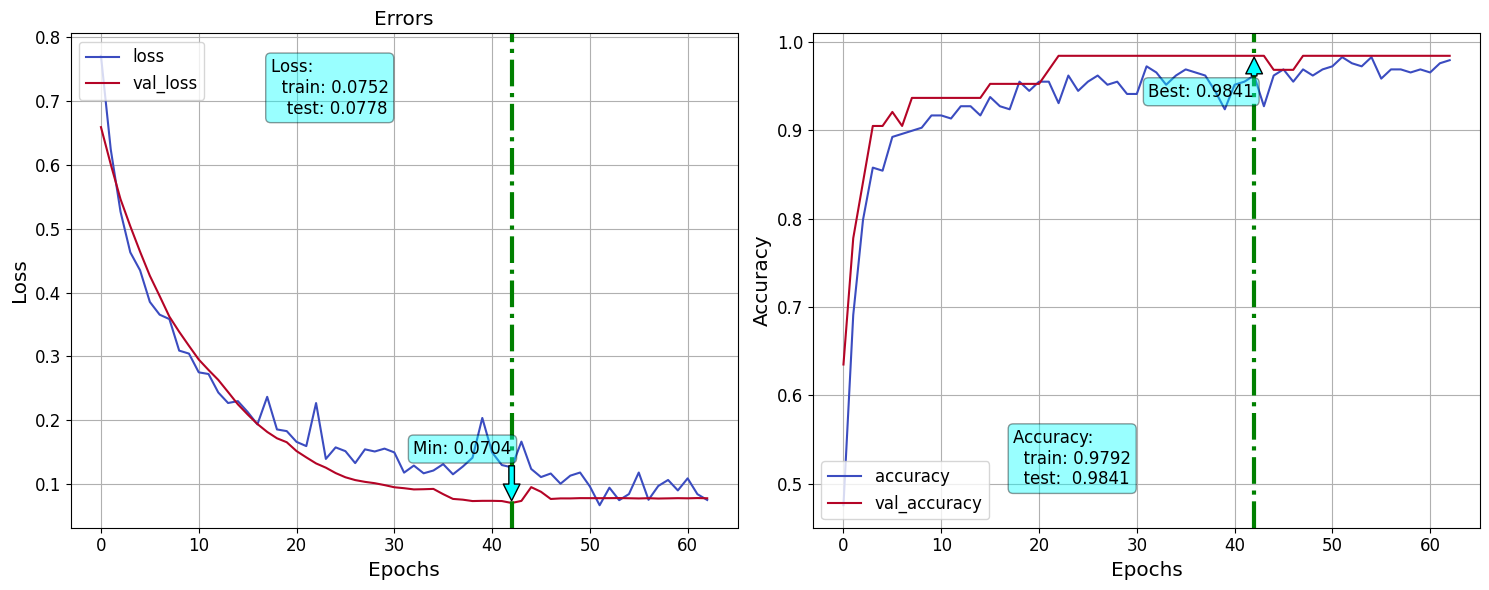

In [33]:
fn_plot_tf_hist(hist_df)

In [34]:
loss_dict = model.evaluate(X_test, y_test, verbose=1 , return_dict=True)

2/2 [==============================] - 0s 3ms/step - loss: 0.0704 - accuracy: 0.9841


In [35]:
loss_dict

{'loss': 0.07041561603546143, 'accuracy': 0.9841269850730896}

In [36]:
hist_df[hist_df['val_loss'] == hist_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy,lr
42,0.126298,0.961806,0.070416,0.984127,0.001


In [37]:
del model
del model1
del model2
del model3
del model4

In [38]:
## Some model functions

initalizer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA) # using Adam optimizer

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

rate = 0.2

model = tf.keras.models.Sequential([
    
    tf.keras.layers.InputLayer( input_shape =(34,)  ),
    
    tf.keras.layers.Dense (26,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation(activation='relu'),

    #tf.keras.layers.Dropout(rate1 , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (18,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation(activation='relu'),

    #tf.keras.layers.Dropout(rate2 , seed = RANDOM_STATE),

    tf.keras.layers.Dense (10,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation(activation='relu'),

    #tf.keras.layers.Dropout(rate3 , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (2),
    
])

model.compile(optimizer=optimizer,
               loss = loss_fn,
               metrics= ['accuracy'])

In [39]:
res = model.evaluate(X_test, y_test, verbose=2, return_dict=True)

res['accuracy']

2/2 - 0s - loss: 0.7155 - accuracy: 0.4603 - 148ms/epoch - 74ms/step


0.460317462682724

In [40]:
model.load_weights(checkpoint_filepath)

In [41]:
res = model.evaluate(X_test, y_test, verbose=2, return_dict=True)

res['accuracy']

2/2 - 0s - loss: 0.0704 - accuracy: 0.9841 - 15ms/epoch - 8ms/step


0.9841269850730896

## Save Complete Model

In [42]:
model_path = os.path.join(modelDir, subDir, 'complete_all_in')

tf.keras.models.save_model(model, model_path)

INFO:tensorflow:Assets written to: ../models/ionosphere/complete_all_in/assets


INFO:tensorflow:Assets written to: ../models/ionosphere/complete_all_in/assets


In [43]:
model1 = tf.keras.models.load_model(model_path)

In [44]:
res = model1.evaluate(X_test, y_test, verbose=2, return_dict=True)

res['accuracy']

2/2 - 0s - loss: 0.0704 - accuracy: 0.9841 - 99ms/epoch - 50ms/step


0.9841269850730896

In [45]:
model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 26)                910       
                                                                 
 batch_normalization_6 (Bat  (None, 26)                104       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 26)                0         
                                                                 
 dense_21 (Dense)            (None, 18)                486       
                                                                 
 batch_normalization_7 (Bat  (None, 18)                72        
 chNormalization)                                                
                                                                 
 activation_7 (Activation)   (None, 18)               